In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg # simple AR model
from statsmodels.tsa.statespace.sarimax import SARIMAX # ARIMA model
import pmdarima as pm # for auto-arima method (same as ARIMA, but more convenient for exploring)

from scipy.stats import linregress

from preprocess import read_data
import scoring

In [154]:
news, Xy_train, Xy_valid, Xy_test = read_data()

         Date                                               News  \
0  2008-08-08   b"Georgia 'downs two Russian warplanes' as co...   
1  2008-08-11   b'Why wont America and Nato help us? If they ...   

                                    PreProcessedNews  Label  
0  georgia two russian warplane country move brin...      0  
1  wont america nato help wont help help iraq bus...      1  
         Date          Open          High           Low         Close  \
0  2016-07-01  17924.240234  18002.380859  17916.910156  17949.369141   
1  2016-06-30  17712.759766  17930.609375  17711.800781  17929.990234   

      Volume     Adj Close  
0   82160000  17949.369141  
1  133030000  17929.990234  


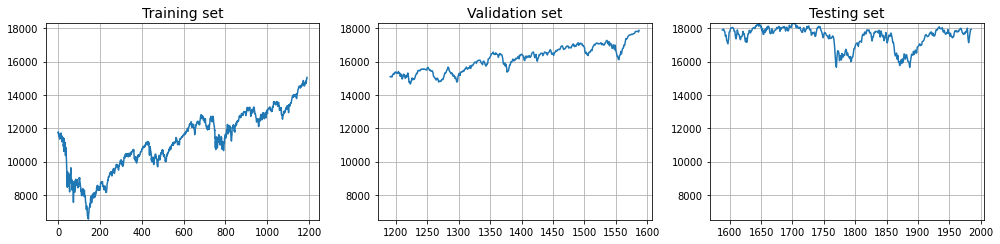

In [155]:
fig,ax = plt.subplots(1,3,figsize=(14,3.5))

ax[0].plot(Xy_train.loc[:,"Close"])
ax[0].set_title("Training set",fontsize=14)
ax[0].grid()
ax[0].set_ylim([6500,18300])

ax[1].plot(Xy_valid.loc[:,"Close"])
ax[1].set_title("Validation set",fontsize=14)
ax[1].grid()
ax[1].set_ylim([6500,18300])

ax[2].plot(Xy_test.loc[:,"Close"])
ax[2].set_title("Testing set",fontsize=14)
ax[2].grid()
ax[2].set_ylim([6500,18300])

plt.tight_layout()
plt.show()

In [156]:
x_train = pd.concat((Xy_train,Xy_valid)).set_index("Date").loc["2010":,"Close"]
y_train = pd.concat((Xy_train,Xy_valid)).set_index("Date").loc["2010":,"Label"]
x_test = Xy_test.set_index("Date").loc[:,"Close"]
y_test = Xy_test.set_index("Date").loc[:,"Label"]

# ARIMA Model

In [157]:
model = pm.auto_arima(x_train,max_p=5,max_d=2,max_q=5,n_jobs=4,return_valid_fits=True)
for k in model[:5]: print(f"{k} --> AIC: {round(k.aic())}")

/home/user/.local/lib/python3.7/site-packages/pmdarima/arima/auto.py:303: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)
/home/user/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/user/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(order=(1, 1, 1)) --> AIC: 15214.0
ARIMA(order=(2, 1, 1)) --> AIC: 15216.0
ARIMA(order=(1, 1, 2)) --> AIC: 15216.0
ARIMA(order=(2, 1, 0)) --> AIC: 15217.0
ARIMA(order=(0, 1, 2)) --> AIC: 15217.0


In [158]:
arima = SARIMAX(x_train,order=model[1].order).fit()

/home/user/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/user/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


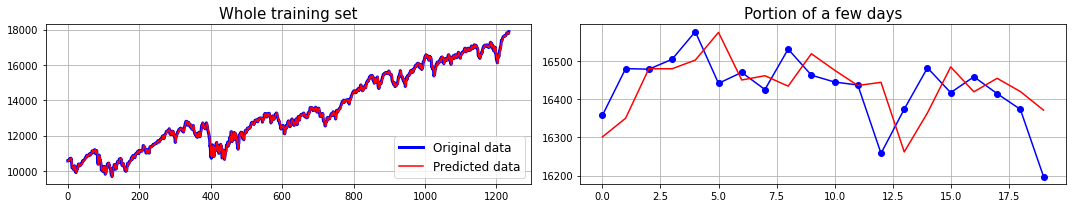

In [159]:
############################
##### REPRESENTATION OF THE TRAINING
start,length = 1000,20

fig,ax = plt.subplots(1,2,figsize=(15,3))

ax[0].grid()
l1 = ax[0].plot(x_train.values[1:],c="b",label="Original data",linewidth=3)
l2 = ax[0].plot(arima.predict(start=1,typ='levels').values,c="r",label="Predicted data")
ax[0].set_title("Whole training set",fontsize=15)
ax[0].legend(l1+l2, [l.get_label() for l in l1+l2],fontsize=12,loc=4)

ax[1].grid()
ax[1].plot(x_train.values[start:start+length],c="b",label="Original data",marker="o")
ax[1].plot(arima.predict(start=1,typ='levels').values[start-1:start-1+length],c="r",label="Predicted data")
ax[1].set_title("Portion of a few days",fontsize=15)

plt.tight_layout()
plt.show()

/home/user/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/user/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Text(0.5, 1.0, 'Joint prediction and data')

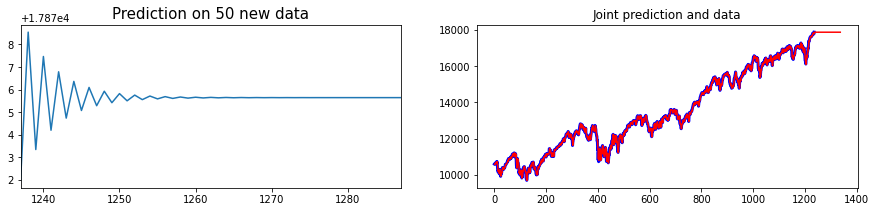

In [160]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
arima.predict(start=len(x_train),end=len(x_train)+50,typ='levels').plot()
plt.title("Prediction on 50 new data",fontsize=15)

plt.subplot(1,2,2)
plt.plot(x_train.values,c="b",linewidth=3)
plt.plot(range(1,len(x_train)+101),
         arima.predict(start=1,end=len(x_train)+100,typ='levels').values,c="r")
plt.title("Joint prediction and data")

/home/user/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/user/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


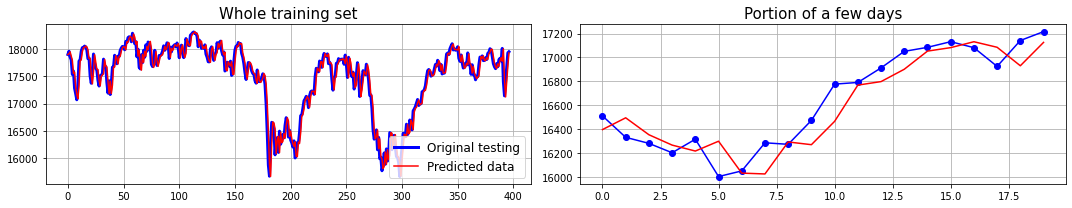

In [161]:
### Real way to predict a value with this trained model:
predictor = SARIMAX(x_test,order=model[1].order).smooth(params=arima.params)


############################
##### REPRESENTATION OF THE TESTING
start,length = 200,20

fig,ax = plt.subplots(1,2,figsize=(15,3))

ax[0].grid()
l1 = ax[0].plot(x_test.values[1:],c="b",label="Original testing",linewidth=3)
l2 = ax[0].plot(predictor.predict(start=1,typ='levels').values,c="r",label="Predicted data")
ax[0].set_title("Whole training set",fontsize=15)
ax[0].legend(l1+l2, [l.get_label() for l in l1+l2],fontsize=12,loc=4)

ax[1].grid()
ax[1].plot(x_test.values[start:start+length],c="b",label="Original testing",marker="o")
ax[1].plot(predictor.predict(start=1,typ='levels').values[start-1:start-1+length],c="r",label="Predicted data")
ax[1].set_title("Portion of a few days",fontsize=15)

plt.tight_layout()
plt.show()

In [162]:
arima.params

ar.L1        -0.784868
ar.L2         0.006086
ma.L1         0.734216
sigma2    12984.629220
dtype: float64

In [163]:
# Test how the labeling work --> you can not predict the first value, this is strict incleasing.
((np.diff(x_test)>0).astype(int) != y_test.values[1:]).sum()

0

In [164]:
y_pred = (np.diff(predictor.predict(start=1).values,n=1)>0).astype(int)
y_pred.shape

(396,)

In [166]:
pd.DataFrame([scoring.evaluation(y_test.values[2:],y_pred),
             scoring.dummy_previous(y_test.values),
             scoring.dummy_increase(y_test.values)]).T

,Prediction,Naive Previous,Naive Increase
precision,0.492386,0.472637,0.507538
recall,0.482587,0.472637,1.000000
f_measure,0.487437,0.472637,0.673333
accuracy,0.484848,0.465995,0.507538


# Function to re-create training and testing sets

In [183]:
from sklearn.preprocessing import StandardScaler

def create_timeShiftSet(X_train,X_test,y_train,y_test,shift=1,del_first=False, scaleX=False, scaleY=False):
    """Function to build a training and testing set composed of previous time steps
    It returns new X_train and X_test matrixes."""
    
    x_gather = pd.concat((X_train,X_test))
    y_gather = pd.concat((y_train,y_test))
    
    # Create the shifted columns
    if type(shift)==int: # if a number of shifts is given
        newX = pd.concat([x_gather.shift(k) for k in range(1+del_first.real,1+del_first.real+shift)],axis=1)
        newX.columns = range(shift)
        newX = newX.interpolate(method="linear").iloc[1+shift:] # Shift creates NaN...
        
        newX_train = newX.loc[X_train.index[1+shift:],:].values
        newX_test = newX.loc[X_test.index,:].values
        newy_train = y_gather.loc[X_train.index[1+shift:]].values
        newy_test = y_gather.loc[X_test.index].values
        
    elif type(shift) in [list,tuple]: # if a list of shifts to respect is given
        newX = pd.concat([x_gather.shift(k) for k in shift],axis=1)
        newX.columns = shift
        newX = newX.interpolate(method="linear").iloc[max(shift):del_first.real:] # Shift creates NaN...
    
        newX_train = newX.loc[X_train.index[max(shift):],:].values
        newX_test = newX.loc[X_test.index,:].values
        newy_train = y_gather.loc[X_train.index[max(shift):]].values
        newy_test = y_gather.loc[X_test.index].values
    
    if scaleX:
        xScaler = StandardScaler().fit(newX_train)
        newX_train = xScaler.transform(newX_train)
        newX_test = xScaler.transform(newX_test)
    if scaleY:
        yScaler = StandardScaler().fit(newy_train.reshape(-1,1))
        newy_train = yScaler.transform(newy_train.reshape(-1,1)).ravel()
        newy_test = yScaler.transform(newy_test.reshape(-1,1)).ravel()
    
    return newX_train, newX_test, newy_train, newy_test

# Initialize the dataset again, this time taking ALL data into account

In [228]:
x_train = pd.concat((Xy_train,Xy_valid)).set_index("Date").loc[:,"Close"]
y_train = pd.concat((Xy_train,Xy_valid)).set_index("Date").loc[:,"Label"]
x_test = Xy_test.set_index("Date").loc[:,"Close"]
y_test = Xy_test.set_index("Date").loc[:,"Label"]

# Basic approach of a Random Forest to see the importance of the previous time steps...

In [229]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [238]:
### Test the classifier with numerical data
Xtr, Xts, ytr, yts = create_timeShiftSet(x_train,x_test,y_train,y_test,shift=10,del_first=False)
rfCN = RandomForestClassifier(n_estimators=300,criterion="gini").fit(Xtr,ytr)
rfCN_predict = rfCN.predict(Xts)
rfCN_scoring = scoring.evaluation(yts,rfCN_predict,name="Classification")
rfCN_importance = rfCN.feature_importances_

In [231]:
Xtr.shape

(1577, 10)

In [232]:
### Test the classifier with binary data (previous classification results)
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=10,del_first=True)
rfB = RandomForestClassifier(n_estimators=300,criterion="gini").fit(Xtr,ytr)
rfB_predict = rfB.predict(Xts)
rfB_scoring = scoring.evaluation(yts,rfB_predict, name="All_Binary")
rfB_importance = rfB.feature_importances_

In [233]:
### Test the regressor with the x data only
Xtr, Xts, ytr, yts = create_timeShiftSet(x_train,x_test,x_train.iloc[1:],x_test,shift=10,del_first=True)
rfR = RandomForestRegressor(n_estimators=300,criterion="mse").fit(Xtr,ytr)
rfR_predict = rfR.predict(Xts)
rfR_scoring = scoring.evaluation((np.diff(yts,n=1)>0).astype(int),(np.diff(rfR_predict,n=1)>0).astype(int),name="Regression")
rfR_importance = rfR.feature_importances_

In [239]:
### Compute score of each model prediction on testing
pd.DataFrame([rfCN_scoring, rfB_scoring, rfR_scoring,
             scoring.dummy_previous(y_test.values),
             scoring.dummy_increase(y_test.values)]).T

,Classification,All_Binary,Regression,Naive Previous,Naive Increase
precision,0.511551,0.506122,0.481675,0.472637,0.507538
recall,0.767327,0.613861,0.457711,0.472637,1.000000
f_measure,0.613861,0.554810,0.469388,0.472637,0.673333
accuracy,0.510050,0.500000,0.476071,0.465995,0.507538


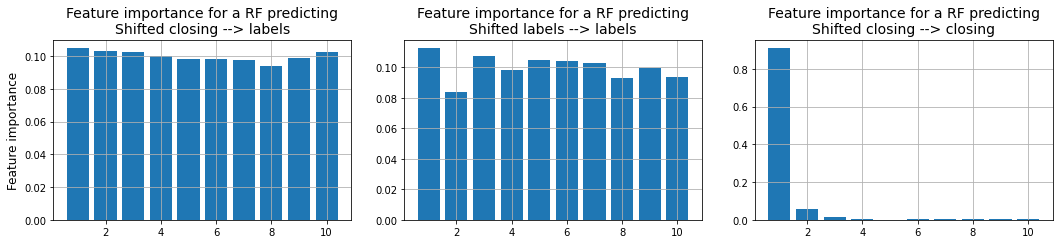

In [235]:
### Plot the importances of the features in each model according to RF
importances = [rfCN_importance, rfB_importance, rfR_importance]
titles = ["Shifted closing --> labels", "Shifted labels --> labels", "Shifted closing --> closing"]

fig,axes = plt.subplots(1,3,figsize=(15,3.5))
for i,ax in enumerate(axes):
    ax.bar(range(1,11),importances[i])
    ax.grid()
    ax.set_title(f"Feature importance for a RF predicting\n{titles[i]}",fontsize=14)
axes[0].set_ylabel("Feature importance",fontsize=12)
    
plt.tight_layout()
plt.show()

**Two conclusions**:
- in terms of results, the first approach is way above. Better to focus on that only... The third might be promising, but the second is simply to abandon.
- in terms of how much data in the past, it seems 10 is good and more would be even better for the first approach... The third method can focus on only 3 time steps in the past.

# SVM Approach
The questions are:
- what value of C ?
- what value of $\gamma$
- the number of time steps to use to train

The steps to take are:
- build a function that allows to build the training and testing sets by rolling the time series data
- make a cross-validation on $C$ and $\gamma$ and roll it over the number of data to look back at.

In [191]:
from sklearn.svm import SVC, SVR

In [192]:
from investigate import GridSearchTotal

### SVM with classification

In [196]:
Xtr, Xts, ytr, yts = create_timeShiftSet(x_train,x_test,y_train,y_test,shift=10,scaleX=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs = GridSearchTotal(SVC,investigate=params_to_explore,model_params={"kernel":'linear'},exercise="C").fit_predict(Xtr,Xts,ytr,yts)
gs.get_report(by="accuracy",ascending=False).head()

,C,gamma,precision,recall,f_measure,accuracy
0,0.001,0.001,0.507538,1.0,0.673333,0.507538
25,1.000,10.000,0.507538,1.0,0.673333,0.507538
27,1.000,1000.000,0.507538,1.0,0.673333,0.507538
28,10.000,0.001,0.507538,1.0,0.673333,0.507538
29,10.000,0.010,0.507538,1.0,0.673333,0.507538


In [197]:
np.unique(gs.get_report().accuracy,return_counts=True)

(array([0.50753769]), array([49]))

In [271]:
Xtr, Xts, ytr, yts = create_timeShiftSet(x_train,x_test,y_train,y_test,shift=10,scaleX=True,scaleY=False)
svm_class = SVC(C=1, gamma=1,kernel="linear").fit(Xtr,ytr)
y_pred = svm_class.predict(Xts)
scoring.evaluation(yts,y_pred)

precision    0.507538
recall       1.000000
f_measure    0.673333
accuracy     0.507538
Name: Prediction, dtype: float64

### SVM with binaries

In [283]:
### Test the classifier with binary data (previous classification results)
# Grid search with linear kernel
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=10,del_first=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs = GridSearchTotal(SVC,investigate=params_to_explore,model_params={"kernel":'linear'},exercise="C").fit_predict(Xtr,Xts,ytr,yts)
gs.get_report(by="accuracy",ascending=False).iloc[[0,1,-2,-1]]

,C,gamma,precision,recall,f_measure,accuracy
0,0.001,0.001,0.507538,1.0,0.673333,0.507538
25,1.000,10.000,0.507538,1.0,0.673333,0.507538
22,1.000,0.010,0.507538,1.0,0.673333,0.507538
48,1000.000,1000.000,0.507538,1.0,0.673333,0.507538


In [255]:
# Grid search with RBF kernel
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=10,del_first=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs = GridSearchTotal(SVC,investigate=params_to_explore,model_params={"kernel":'rbf'},exercise="C").fit_predict(Xtr,Xts,ytr,yts)
gs.get_report(by="accuracy",ascending=False).iloc[[0,1,-2,-1]]

,C,gamma,precision,recall,f_measure,accuracy
48,1000.0,1000.00,0.511475,0.772277,0.615385,0.510050
36,100.0,0.01,0.508816,1.000000,0.674457,0.510050
24,1.0,1.00,0.481481,0.643564,0.550847,0.467337
44,1000.0,0.10,0.472000,0.584158,0.522124,0.457286


In [256]:
# Grid search with sigmoid kernel
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=10,del_first=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs = GridSearchTotal(SVC,investigate=params_to_explore,model_params={"kernel":'sigmoid'},exercise="C").fit_predict(Xtr,Xts,ytr,yts)
gs.get_report(by="accuracy",ascending=False).iloc[[0,1,-2,-1]]

,C,gamma,precision,recall,f_measure,accuracy
20,0.100,1000.000,0.534979,0.643564,0.584270,0.535176
19,0.100,100.000,0.534979,0.643564,0.584270,0.535176
0,0.001,0.001,0.507538,1.000000,0.673333,0.507538
37,100.000,0.100,0.500000,0.539604,0.519048,0.492462


In [258]:
### Compute BEST and WORST cases for each
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=10,del_first=True)

y_pred = []
case = ["linear","linear","sigmoid","sigmoid","rbf","rbf"]
names = ["linear_best","linear_worse","sigmoid_best","sigmoid_worse","rbf_best","rbf_worse"]
params = {"linear_best":{"C":1, "gamma":.1, "kernel":"linear"},
          "linear_worse":{"C":1, "gamma":.1, "kernel":"linear"},
          "sigmoid_best":{"C":.1, "gamma":100, "kernel":"sigmoid"},
          "sigmoid_worse":{"C":100, "gamma":.1, "kernel":"sigmoid"},
          "rbf_best":{"C":100, "gamma":.01, "kernel":"rbf"},
          "rbf_worse":{"C":1000, "gamma":.1, "kernel":"rbf"}}

for n in names:
    svm = SVC(**params[n]).fit(Xtr,ytr)
    y_pred.append(svm.predict(Xts))

pd.DataFrame([scoring.evaluation(yts,y_pred[i], name=names[i]) for i in range(6)]).T

,linear_best,linear_worse,sigmoid_best,sigmoid_worse,rbf_best,rbf_worse
precision,0.507538,0.507538,0.534979,0.500000,0.508816,0.472000
recall,1.000000,1.000000,0.643564,0.539604,1.000000,0.584158
f_measure,0.673333,0.673333,0.584270,0.519048,0.674457,0.522124
accuracy,0.507538,0.507538,0.535176,0.492462,0.510050,0.457286


### SVM with regression

In [254]:
### Test the Regressor approach
# Grid search with linear kernel
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=2,del_first=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs = GridSearchTotal(SVR,investigate=params_to_explore,model_params={"kernel":'linear'},exercise="C").fit_predict(Xtr,Xts,ytr,yts)
gs.get_report(by="accuracy",ascending=False).iloc[[0,1,-2,-1]]

Xtr, Xts, ytr, yts = create_timeShiftSet(x_train,x_test,x_train.iloc[1:],x_test,shift=2,del_first=False,scaleX=True,scaleY=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs_R = GridSearchTotal(SVR,investigate=params_to_explore,model_params={"kernel":'rbf'},exercise="R").fit_predict(Xtr,Xts,ytr,yts)
gs_R.get_report(by="accuracy",ascending=False).head()

,C,gamma,precision,recall,f_measure,accuracy
0,0.001,0.001,0.507538,1.0,0.673333,0.507538
25,1.000,10.000,0.507538,1.0,0.673333,0.507538
22,1.000,0.010,0.507538,1.0,0.673333,0.507538
48,1000.000,1000.000,0.507538,1.0,0.673333,0.507538


In [255]:
# Grid search with RBF kernel
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=10,del_first=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs = GridSearchTotal(SVC,investigate=params_to_explore,model_params={"kernel":'rbf'},exercise="C").fit_predict(Xtr,Xts,ytr,yts)
gs.get_report(by="accuracy",ascending=False).iloc[[0,1,-2,-1]]

,C,gamma,precision,recall,f_measure,accuracy
48,1000.0,1000.00,0.511475,0.772277,0.615385,0.510050
36,100.0,0.01,0.508816,1.000000,0.674457,0.510050
24,1.0,1.00,0.481481,0.643564,0.550847,0.467337
44,1000.0,0.10,0.472000,0.584158,0.522124,0.457286


In [256]:
# Grid search with sigmoid kernel
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=10,del_first=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs = GridSearchTotal(SVC,investigate=params_to_explore,model_params={"kernel":'sigmoid'},exercise="C").fit_predict(Xtr,Xts,ytr,yts)
gs.get_report(by="accuracy",ascending=False).iloc[[0,1,-2,-1]]

,C,gamma,precision,recall,f_measure,accuracy
20,0.100,1000.000,0.534979,0.643564,0.584270,0.535176
19,0.100,100.000,0.534979,0.643564,0.584270,0.535176
0,0.001,0.001,0.507538,1.000000,0.673333,0.507538
37,100.000,0.100,0.500000,0.539604,0.519048,0.492462


In [258]:
### Compute BEST and WORST cases for each
Xtr, Xts, ytr, yts = create_timeShiftSet(y_train,y_test,y_train.iloc[1:],y_test,shift=10,del_first=True)

y_pred = []
case = ["linear","linear","sigmoid","sigmoid","rbf","rbf"]
names = ["linear_best","linear_worse","sigmoid_best","sigmoid_worse","rbf_best","rbf_worse"]
params = {"linear_best":{"C":1, "gamma":.1, "kernel":"linear"},
          "linear_worse":{"C":1, "gamma":.1, "kernel":"linear"},
          "sigmoid_best":{"C":.1, "gamma":100, "kernel":"sigmoid"},
          "sigmoid_worse":{"C":100, "gamma":.1, "kernel":"sigmoid"},
          "rbf_best":{"C":100, "gamma":.01, "kernel":"rbf"},
          "rbf_worse":{"C":1000, "gamma":.1, "kernel":"rbf"}}

for n in names:
    svm = SVC(**params[n]).fit(Xtr,ytr)
    y_pred.append(svm.predict(Xts))

pd.DataFrame([scoring.evaluation(yts,y_pred[i], name=names[i]) for i in range(6)]).T

,linear_best,linear_worse,sigmoid_best,sigmoid_worse,rbf_best,rbf_worse
precision,0.507538,0.507538,0.534979,0.500000,0.508816,0.472000
recall,1.000000,1.000000,0.643564,0.539604,1.000000,0.584158
f_measure,0.673333,0.673333,0.584270,0.519048,0.674457,0.522124
accuracy,0.507538,0.507538,0.535176,0.492462,0.510050,0.457286


In [281]:
# Now let's do it for regression
Xtr, Xts, ytr, yts = create_timeShiftSet(x_train,x_test,x_train.iloc[1:],x_test,shift=2,del_first=False,scaleX=True,scaleY=True)
params_to_explore = {"C":np.logspace(-3,3,7),"gamma":np.logspace(-3,3,7)}
gs_R = GridSearchTotal(SVR,investigate=params_to_explore,model_params={"kernel":'rbf'},exercise="R").fit_predict(Xtr,Xts,ytr,yts)
gs_R.get_report(by="accuracy",ascending=False).head()

,C,gamma,precision,recall,f_measure,accuracy
17,0.100,1.0,0.573684,0.542289,0.557545,0.564232
18,0.100,10.0,0.550000,0.547264,0.548628,0.544081
39,100.000,10.0,0.546798,0.552239,0.549505,0.541562
32,10.000,10.0,0.546341,0.557214,0.551724,0.541562
5,0.001,100.0,0.549451,0.497512,0.522193,0.539043


In [205]:
np.unique(gs_R.get_report().accuracy,return_counts=True)

(array([0.44584383, 0.44836272, 0.45088161, 0.4559194 , 0.46095718,
        0.47103275]),
 array([ 7,  7,  7, 14,  7,  7]))

In [240]:
gs_R.get_report(by="accuracy",ascending=True).head(7)

,C,gamma,precision,recall,f_measure,accuracy
19,0.1,100.000,0.454976,0.477612,0.466019,0.445844
20,0.1,1000.000,0.454976,0.477612,0.466019,0.445844
18,0.1,10.000,0.454976,0.477612,0.466019,0.445844
17,0.1,1.000,0.454976,0.477612,0.466019,0.445844
16,0.1,0.100,0.454976,0.477612,0.466019,0.445844
15,0.1,0.010,0.454976,0.477612,0.466019,0.445844
14,0.1,0.001,0.454976,0.477612,0.466019,0.445844


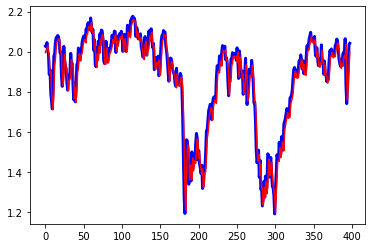

precision    0.468293
recall       0.477612
f_measure    0.472906
accuracy     0.460957
Name: Prediction, dtype: float64

In [211]:

Xtr, Xts, ytr, yts = create_timeShiftSet(x_train,x_test,x_train.iloc[1:],x_test,shift=3,del_first=False,scaleX=True,scaleY=True)
y_out = SVR(C=1000, gamma=1.0, kernel='linear').fit(Xtr,ytr).predict(Xts)
plt.plot(yts,c="b",linewidth="3")
plt.plot(y_out,c="r")
plt.show()

scoring.evaluation(scoring.reg_to_binary(yts.ravel()),scoring.reg_to_binary(y_out))

## WEird translation to the Apple dataset

In [94]:
apple = pd.read_csv("AppleFinalData.csv",index_col=0)
apple["Labels"] = np.concatenate(((np.diff(apple.Close.values)>0).astype(int),np.full((1,),np.nan))).astype(int)
apple = apple.interpolate(method="linear").iloc[:-1]

Xtr = apple.iloc[:int(.8*apple.shape[0])]["Close"]
Xts = apple.iloc[int(.8*apple.shape[0]):]["Close"]
ytr = apple.iloc[:int(.8*apple.shape[0])]["Labels"]
yts = apple.iloc[int(.8*apple.shape[0]):]["Labels"]

Xtr,Xts,ytr,yts = create_timeShiftSet(Xtr,Xts,ytr,yts,shift=10,scaleX=False)

y_pred = svm_class.predict(Xts) # predict without training, with the old object.
scoring.evaluation(yts,y_pred)

precision    0.666667
recall       0.016260
f_measure    0.031746
accuracy     0.515873
Name: Prediction, dtype: float64

In [104]:
Xtr = apple.iloc[:int(.8*apple.shape[0])]["Close"]
Xts = apple.iloc[int(.8*apple.shape[0]):]["Close"]
ytr = apple.iloc[:int(.8*apple.shape[0])]["Labels"]
yts = apple.iloc[int(.8*apple.shape[0]):]["Labels"]
Xtr,Xts,ytr,yts = create_timeShiftSet(Xtr,Xts,ytr,yts,shift=10,scaleX=True)

params_to_explore = {"C":np.logspace(-3,1,5),"gamma":np.logspace(-3,3,7)}
gs = GridSearchTotal(SVC,investigate=params_to_explore,model_params={"kernel":'linear'},exercise="C").fit_predict(Xtr,Xts,ytr,yts)
gs.get_report(by="accuracy",ascending=False).head()

,C,gamma,precision,recall,f_measure,accuracy
0,0.001,0.001,0.488095,1.0,0.656,0.488095
26,1.000,100.000,0.488095,1.0,0.656,0.488095
20,0.100,1000.000,0.488095,1.0,0.656,0.488095
21,1.000,0.001,0.488095,1.0,0.656,0.488095
22,1.000,0.010,0.488095,1.0,0.656,0.488095


In [105]:
svm_class = SVC(C=1, gamma=1e-2,kernel="linear").fit(Xtr,ytr)
y_pred = svm_class.predict(Xts)
scoring.evaluation(yts,y_pred)

precision    0.488095
recall       1.000000
f_measure    0.656000
accuracy     0.488095
Name: Prediction, dtype: float64